In [17]:
import numpy as np
import torch
import torchdiffeq
import matplotlib.pyplot as plt
# import cvxpy as cp

In [18]:
toy_example = True
if toy_example:
    dimX=20; dimY=20

    c = torch.load('data/c.pt')
    d = torch.load('data/d.pt')
    A = torch.load('data/A.pt')
    H = torch.load('data/H.pt')

    def f(x, y):
        return torch.sin(c.T @ x + d.T @ y) + torch.log(torch.linalg.norm(x+y)**2 + 1)

    def g(x, y):
        return 0.5 * torch.linalg.norm(H@y - x)**2
else:
    A_tr = torch.load('data/A_tr.pt').to(torch.float32)
    B_tr = torch.load('data/B_tr.pt').to(torch.float32)

    A_val = torch.load('data/A_val.pt').to(torch.float32)
    B_val = torch.load('data/B_val.pt').to(torch.float32)

    A_test = torch.load('data/A_test.pt').to(torch.float32)
    B_test = torch.load('data/B_test.pt').to(torch.float32)

    lam = 0.01      # Regularization parameter
    dimX = A_tr.shape[0]; dimY = A_tr.shape[1];

    n_train = A_tr.shape[0]
    n_val = A_val.shape[0]
    n_test = A_test.shape[0]


    def f(x, y):
        loss = 1 / n_val * torch.sum(torch.log(1 + torch.exp(-B_val * (A_val @ y)[:, 0])))
        return loss.unsqueeze(0).unsqueeze(0)

    def g(x, y):
        return 1 / n_train * torch.sum(torch.log(1 + torch.exp(-B_tr * (A_tr @ y)[:, 0])) * (1 / (1 + torch.exp(-x)[:, 0]))) + lam * torch.linalg.norm(y)**2


/tmp/ipykernel_34090/378878840.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  c = torch.load('data/c.pt')
/tmp/ipykernel_34090/378878840.py:6: FutureWarning: You are us

In [19]:
def calc_derivatives(x, y):
    f_val = f(x,y)
    g_val = g(x,y)

    # 1st derivatives
    dfdy = torch.autograd.grad(f_val, y, create_graph=True, allow_unused=True, materialize_grads=True)[0]
    dfdx = torch.autograd.grad(f_val, x, create_graph=True, allow_unused=True, materialize_grads=True)[0]

    dgdy = torch.autograd.grad(g_val, y, create_graph=True, allow_unused=True, materialize_grads=True)[0]
    dgdx = torch.autograd.grad(g_val, x, create_graph=True, allow_unused=True, materialize_grads=True)[0]

    # Initialize tensors for 2nd derivatives
    dgdyy = torch.zeros((dimY, dimY))
    dgdyx = torch.zeros((dimY, dimX))
    # Compute 2nd derivatives element-wise
    for i in range(dgdy.shape[0]):
        dgdyy[i, :] = torch.autograd.grad(dgdy[i], y, retain_graph=True, create_graph=True, allow_unused=True, materialize_grads=True)[0][:, 0]
        dgdyx[i, :] = torch.autograd.grad(dgdy[i], x, retain_graph=True, create_graph=True, allow_unused=True, materialize_grads=True)[0][:, 0]
    
    return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx

def calc_derivatives_analytic(x, y):
    dfdx = torch.cos(c.T @ x + d.T @ y) * c + 2 *(x+y) / (torch.linalg.norm(x+y)**2 + 1)
    dfdy = torch.cos(c.T @ x + d.T @ y) * d + 2 * (x+y) / (torch.linalg.norm(x+y)**2 + 1)

    dgdx = - (H @ y - x)
    dgdy = H.T @ (H @ y - x)

    dgdyy = H.T @ H
    dgdyx = -H
    
    return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx

calc_derivatives = calc_derivatives_analytic

In [20]:
def solveLL(x):
    y = torch.randn((dimY, 1), requires_grad=True, dtype=torch.float32)
    lr = 1e-1
    while True:
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        HessianInv = dgdyy.inverse()
        if torch.linalg.norm(dgdy, 2) < 1e-3:
            break
        with torch.no_grad():
            y -= lr * HessianInv @ dgdy
    return y

# Define the system of ODEs
def system(t, variables):
    if np.allclose(t % 1, 0):
        print(t)
    mu = 0.01
    x, y = variables[:dimX], variables[dimX:]
    global dxdt #Because its previous value is required in ProjectMethod 1
    
    dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
    with torch.no_grad():    
        if inversionFree:
            # if projectionMethod == 1:
            if False:
                a = 2 * dgdyy @ dgdy
                b = -2 * dgdy.T @ dgdyx @ dxdt - alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
                d = a * torch.maximum(torch.Tensor([0]), -a.T @ dfdy - b) / torch.linalg.norm(a, 2)**2

                dxdt = -dfdx - dgdyx.T @ d
                dydt = -dfdy - d

            else:
                a = 2 * dgdyx.T @ dgdy
                b = 2 * dgdyy @ dgdy
                c = -alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
                ab = torch.cat((a, b), 0)

                tot = torch.cat((dfdx, dfdy), 0)
                # tot = torch.cat((dfdx, dgdy), 0)
                d = ab * torch.maximum(torch.Tensor([0]), -ab.T @ tot - c) / (torch.linalg.norm(a, 2)**2 + torch.linalg.norm(b, 2)**2)
                dtotdt = -tot - d
                dxdt = dtotdt[:dimX]; dydt = dtotdt[dimX:]
                
            if torch.linalg.norm(dgdy, 2) > epsilon and not torch.allclose(torch.linalg.norm(dgdy, 2), torch.Tensor([epsilon])):
                    print('t=',t, '-', torch.linalg.norm(dgdy, 2), epsilon)
        else:
            gHessianInv = dgdyy.inverse()
            dxdt = -dfdx + dgdyx.T @ gHessianInv @ dfdy
            dydt = -gHessianInv @ (mu * dgdy + dgdyx @ dxdt)    
    
    return torch.cat((dxdt, dydt), 0)

LL error:  tensor(0.0010, grad_fn=<AmaxBackward0>)
tensor(0.)
tensor(50.)
LL error:  tensor(0.0010, grad_fn=<AmaxBackward0>)
tensor(0.)
tensor(50.)


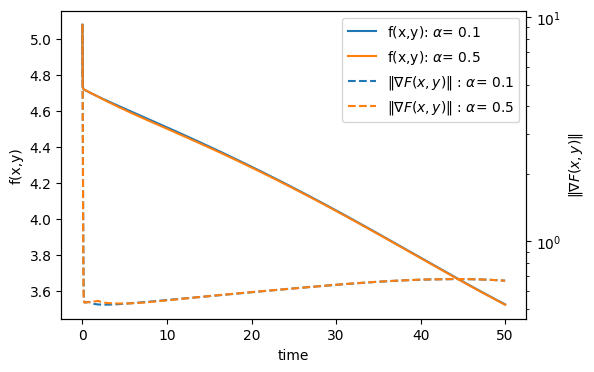

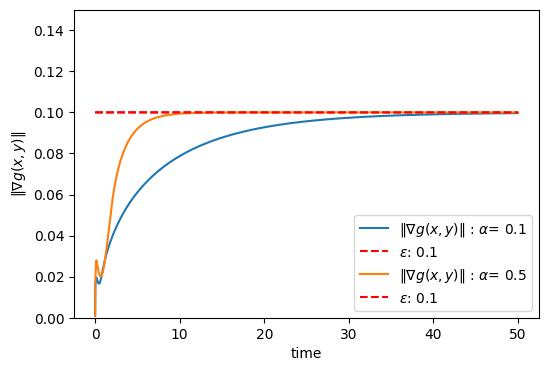

In [24]:
fig1, axs = plt.subplots(1, 1, figsize=(6, 4))
ax1 = axs; 
ax2 = axs.twinx()
fig2, axs = plt.subplots(1, 1, figsize=(6, 4))
ax3 = axs;
lines=[]
test_alpha = True
# (False, None, None), 
for (inversionFree, alpha) in [(True, 0.1), (True, 0.5)]:
    for epsilon in [0.1]:
        torch.manual_seed(0)
        x = torch.randn((dimX, 1), requires_grad=True, dtype=torch.float32)
        y = solveLL(x)
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        print('LL error: ', torch.linalg.norm(dgdy, 2))
        # Time points where the solution is computed
        # t = torch.linspace(0, 400, 40000)
        t = torch.linspace(0, 50, 5000)


        # Solve the system of ODEs
        initial_conditions = torch.cat((x, y), 0)
        dxdt = torch.zeros((dimX, 1))
        solution = torchdiffeq.odeint(system, initial_conditions, t, method='rk4')

        lossF, lossG, lossF2 = [], [], []
        for i in range(len(solution)):
            lossF.append(f(solution[i, :dimX], solution[i, dimX:])[0].detach().numpy())
            dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(solution[i, :dimX], solution[i, dimX:])
            lossG.append(torch.linalg.norm(dgdy).detach().numpy())
            lossF2.append(torch.linalg.norm(dfdx - dgdyx.T @ dgdyy.inverse() @ dfdy).detach().numpy())


        line1,  = ax1.plot(t, lossF, label= ('f(x,y):' + 
                                            ((r' $\alpha$= ' + str(alpha)) if test_alpha else r' $\varepsilon$= ' + str(epsilon))))
        line2,  = ax2.plot(t, lossF2, '--', label=(r'$\|\nabla F(x,y)\|$ :' + 
                                            ((r' $\alpha$= ' + str(alpha)) if test_alpha else r' $\varepsilon$= ' + str(epsilon))))
        lines.append(line1); lines.append(line2)
        # -----------------------------------------------------
        ax3.plot(t, lossG, label=(r'$\|\nabla g(x,y)\|$ :' + 
                                    ((r' $\alpha$= ' + str(alpha)) if test_alpha else r' $\varepsilon$= ' + str(epsilon))))

        ax3.plot(t, [epsilon] * len(t), 'r--', label=r'$\varepsilon$: ' + str(epsilon))

lines = np.array(lines)[[0, 2, 1, 3]]
ax1.legend(lines, [line.get_label() for line in lines], loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('f(x,y)')
ax2.set_ylabel(r'$\|\nabla F(x,y)\|$')
ax2.set_yscale('log')

ax3.legend()
ax3.set_xlabel('time')
ax3.set_ylabel(r'$\|\nabla g(x,y)\|$')
ax3.set_ylim([0, 1.5 * epsilon])


# plt.tight_layout()
fig1.savefig('Result/' + ('toy_example' if toy_example else 'DHC') + str(test_alpha) + '-up' + '.pdf', dpi=300)
fig2.savefig('Result/' + ('toy_example' if toy_example else 'DHC') + str(test_alpha) + '-low' + '.pdf', dpi=300)
# plt.show()

In [22]:
if not toy_example:
    import torch
    import matplotlib.pyplot as plt

    # Helper function to calculate accuracy
    def calculate_accuracy(A, B, W):
        predictions = A @ W
        predicted_labels = torch.sign(predictions)
        correct_predictions = (predicted_labels[:, 0] == B).float().sum()
        return correct_predictions / B.size(0)

    # Helper function to calculate loss
    def calculate_loss(A, B, W, n_samples):
        loss = 1 / n_samples * torch.sum(torch.log(1 + torch.exp(-B * (A @ W)[:, 0])))
        return loss.unsqueeze(0).unsqueeze(0)

    # Lists to store metrics
    train_accuracy, val_accuracy, test_accuracy = [], [], []
    train_loss, val_loss, test_loss = [], [], []

    # Calculate metrics for each solution
    with torch.no_grad():
        for i in range(len(solution)):
            W = solution[i, dimX:]

            # Train accuracy and loss
            train_accuracy.append(calculate_accuracy(A_tr, B_tr, W))
            train_loss.append(calculate_loss(A_tr, B_tr, W, n_train))

            # Validation accuracy and loss
            val_accuracy.append(calculate_accuracy(A_val, B_val, W))
            val_loss.append(calculate_loss(A_val, B_val, W, n_val))

            # Test accuracy and loss
            test_accuracy.append(calculate_accuracy(A_test, B_test, W))
            test_loss.append(calculate_loss(A_test, B_test, W, n_test))

        # Plotting accuracy
        plt.figure(figsize=(16, 5))
        plt.subplot(1, 2, 1)
        # plt.plot(t, train_accuracy, label='Train Accuracy')
        plt.plot(t, val_accuracy, label='Validation Accuracy')
        plt.plot(t, test_accuracy, label='Test Accuracy')
        plt.xlabel('time')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plotting loss
        plt.subplot(1, 2, 2)
        # plt.plot(t, train_loss, label='Train Loss')
        plt.plot(t, val_loss, label='Validation Loss')
        plt.plot(t, test_loss, label='Test Loss')
        plt.xlabel('time')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()
